# membrane + chloride
+ special Pf_RS and RS_plot
+ limit state: structure age > membrane life

In [80]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from membrane import Membrane_Model
from chloride import Chloride_Model, load_df_D_RCM, C_crit_param, C_eqv_to_C_S_0
import helper_func as hf
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
# Case study
# global
class Param: pass

mem_pars = Param()

# product information
mem_pars.life_product_label_life = 10  # year, defined as 95% confident non-failure
mem_pars.life_std = 0.2 * mem_pars.life_product_label_life # assume, calibrate later
mem_pars.life_confidence = 0.95

Pf(g = R-S < 0) from various methods
    sample count: 0.15909
    g integral: 0.16037505033508428
    R S integral: 0.15865525393145707
    beta_factor: 0.9967597834678902


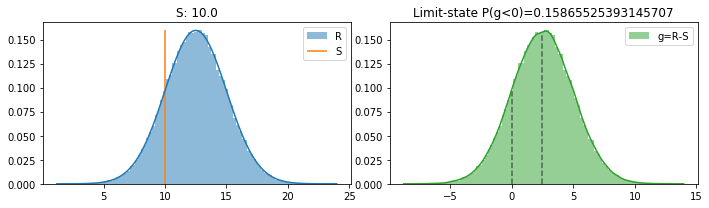

In [82]:
# run model
mem_model_with_main = Membrane_Model(mem_pars)
mem_model_no_main = mem_model_with_main.copy()


# overite with known values
# with no maintenence
mem_model_no_main.pars.life_mean = 12.5 
mem_model_no_main.pars.life_std = 2.5

# with maintenence
mem_model_with_main.pars.life_mean = 35
mem_model_with_main.pars.life_std = 5


mem_model_no_main.run(10)
mem_model_no_main.postproc(plot=True)

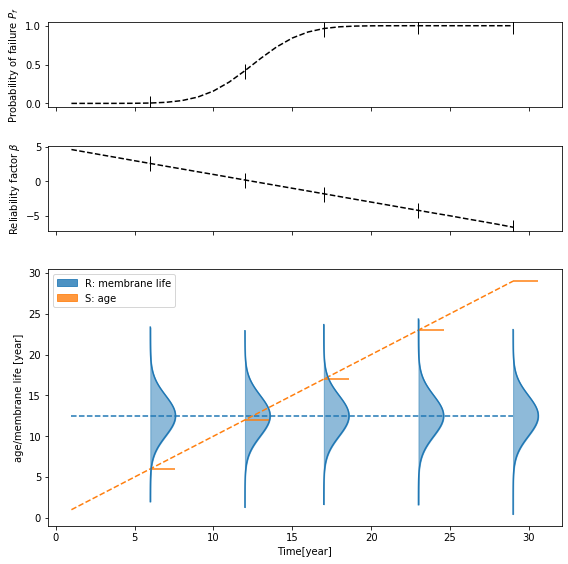

In [83]:
year_lis = np.arange(1,30,1)
pf_mem, beta_mem = mem_model_no_main.membrane_failure_with_year(year_lis, amplify=10)
plt.savefig('plots/membrane_year.pdf', dpi=600)

In [84]:
# put results in a pandas dataframe and save to disk
df_mem = pd.DataFrame({'year': year_lis, 'pf': pf_mem, 'beta': beta_mem})
df_mem.to_csv("tables/membrane_year.csv", index=None)

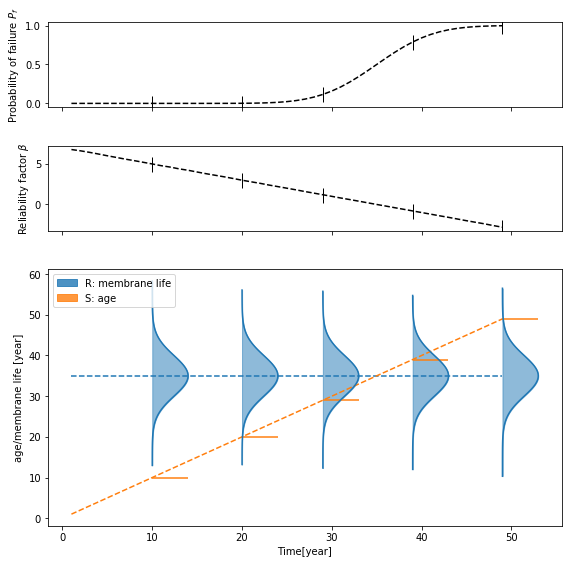

In [86]:
year_lis_main = np.arange(1,50,1)
pf_mem_main, beta_mem_main = mem_model_with_main.membrane_failure_with_year(year_lis_main, amplify=50)
plt.savefig('plots/membrane_main_year.pdf', dpi=600)

In [71]:
# put results in a pandas dataframe and save to disk
df_mem_main = pd.DataFrame({'year': year_lis_main, 'pf': pf_mem_main, 'beta': beta_mem_main})
df_mem_main.to_csv("tables/membrane_main_year.csv", index=None)

# Chloride

In [25]:
load_df_D_RCM()

,CEM_I_42.5_R,CEM_I_42.5_R+FA,CEM_I_42.5_R+SF,CEM_III/B_42.5
wc_eqv,,,,
0.35,NaN,NaN,4.4,NaN
0.40,8.9,5.6,4.8,8.3
0.45,10.0,6.9,NaN,1.9
0.50,15.8,9.0,NaN,2.8
0.55,17.9,10.9,5.3,3.0
0.60,25.0,14.9,NaN,3.4


In [26]:
# global

cl_pars = Param()

cl_pars.marine = True

# 1)marine or coastal
cl_pars.C_0_M = 18.980 # natural chloirde content of sea water [g/l] https://www.lenntech.com/composition-seawater.htm

# 2) de icing salt (hard to quantify)
cl_pars.C_0_R = 0  # average chloride content of the chloride contaminated water [g/l]
cl_pars.n = 0      # average number of salting events per year [-]
cl_pars.C_R_i = 0  # average amount of chloride spread within one spreading event [g/m2]
cl_pars.h_S_i = 1  # amount of water from rain and melted snow per spreading period [l/m2]

cl_pars.exposure_condition = 'submerged'


cl_pars.T_real = 273 + 25

cl_pars.D_RCM_test = 'N/A'
cl_pars.concrete_type = 'Portland cement concrete'
cl_pars.cement_concrete_ratio = 300./2400.
cl_pars.C_0 = 0
cl_pars.C_crit_distrib_param = C_crit_param()

cl_pars.option = Param()
cl_pars.option.choose = True
cl_pars.option.cement_type = 'CEM_I_42.5_R'
cl_pars.option.wc_eqv = 0.5
cl_pars.option.df_D_RCM_0 = load_df_D_RCM()
cl_pars.C_eqv_to_C_S_0 = C_eqv_to_C_S_0

cover_depth = hf.Normal_custom(70, 30, non_negative=True)


Pf(g = R-S < 0) from various methods
    sample count: 0.36555
    g integral: 0.36643586810348955
    R S integral: 0.36640029448078126
    beta_factor: 0.16535867196102957


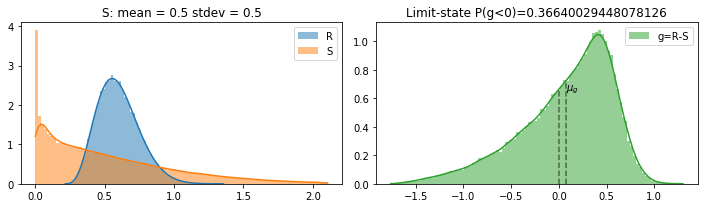

In [27]:
# run model - example at t = 10 years
cl_model = Chloride_Model(cl_pars)
cl_model.run(x = cover_depth, t = 10)
cl_model.postproc(plot=True)

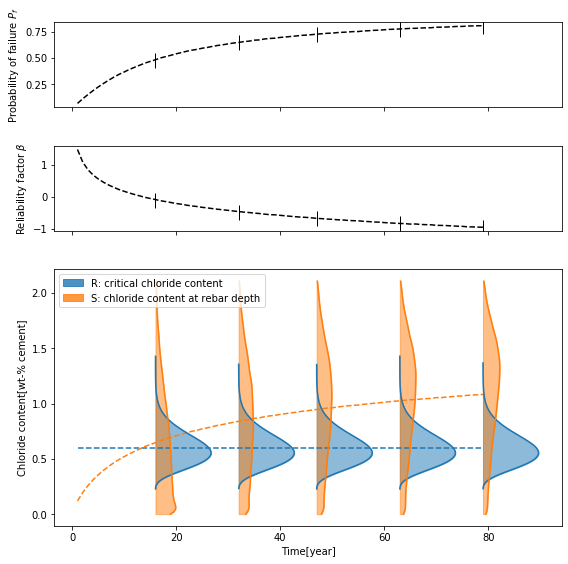

In [59]:
year_lis_cl = np.arange(1,80,1)
pf_cl, beta_cl = cl_model.chloride_with_year(depth=cover_depth, year_lis=year_lis_cl, amplify = 4)
plt.savefig('plots/chloride_year.pdf', dpi=600)

In [87]:
# put results in a pandas dataframe and save to disk
df_cl = pd.DataFrame({'year': year_lis_cl, 'pf': pf_cl, 'beta': beta_cl})
df_cl.to_csv("tables/chloride_year.csv", index=None)

# Combined probability of chloride-indueced corrosion at time t

+ Now we have the probability of the onset of chloride diffusion/membrane breakdown, 〖p_f〗_m Then we know the at a given historical time stamp t_i there is chloride diffusion started with a incremental probability of Δ〖p_f〗_(m,t_i ), and for that time portion, it ends up with the chloride diffusion duration of (t - t_i) with a p_(f_(cl,(t-t_i)) ) of chloride reaching limit state. By deviding and wrapping of all the time steps, we have the P_f of chloride-induced corrosion combing both membrane breakdown and chloride diffusion.
+ sudo code

t -> t_list

incremental delta_pf_mem = diff(pf_mem)

1- product 1-delta_pf_mem(@ ti) * pf_chloride (0->ti) for ti in all time step t=[0,1,...ti...t] 




In [41]:
def pf_mem_cl(t, pf_membrane_t_curve, pf_cl_t_curve):
    """
    returns the propagated total probability of membrane failure and chloride-induced corrosion

    input:
    interpolation curves pf_membrane_t_curve = (t_lis, pf_lis), 
    pf_cl_t_curve = (x_loss_array, p_surface_crack_array)
    
    """
    pf_mem_cl_t = []

    t_mem, pf_mem = pf_membrane_t_curve
    t_cl, pf_cl = pf_cl_t_curve

    for ti in t:
        # inspection in this_year ti
        t_lis = t[0 : np.where(t == ti)[0][0] + 1]
        age_lis = ti - t
        age_lis = age_lis[age_lis >= 0]  # positive duration

        # interpolate membrane pf curve
        pf_mem_lis = np.interp(
            age_lis, t_mem, pf_mem, left=pf_mem.min(), right=pf_mem.max()
        )

        # interpolate chloride pf curve
        pf_cl_lis = np.interp(age_lis, t_cl, pf_cl, left=pf_cl.min(), right=pf_cl.max())

        pf_mem_increment = np.diff(pf_mem_lis, prepend=0)
        pf_mem_cl_t.append(1- np.prod((1-pf_cl_lis * pf_mem_increment)))

    return np.array(pf_mem_cl_t)



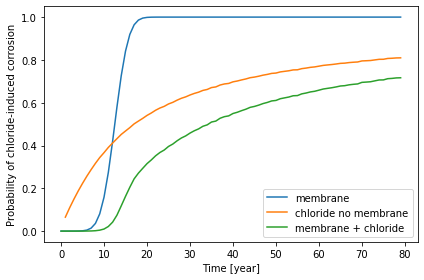

In [92]:
t = np.arange(0, 80, 1)

# horizontal bar external surface
pf_mem_cl_t = pf_mem_cl(
    t,
    pf_membrane_t_curve=(year_lis, pf_mem),
    pf_cl_t_curve=(year_lis_cl, pf_cl)
)


fig, ax = plt.subplots()
ax.plot(t, np.interp(t, year_lis, pf_mem, left=pf_mem.min(), right=pf_mem.max()), "-", label="membrane")

ax.plot(t[1:], np.interp(t, year_lis_cl, pf_cl, left=pf_cl.min(), right=pf_cl.max())[1:], "-", label="chloride no membrane")

ax.plot(t, pf_mem_cl_t, "-", label="membrane + chloride")

# ax.set_xlim(-5, 160)
ax.set_xlabel("Time [year]")
ax.set_ylabel("Probability of chloride-induced corrosion")
plt.tight_layout()
plt.legend()


# fig.savefig('plots/pf_membrane_and_chloride_total.pdf', dpi=600)
df_membrane_and_chloride = pd.DataFrame({'year':t, 
'membrane': np.interp(t, year_lis, pf_mem, left=pf_mem.min(), right=pf_mem.max()),
'chloride no membrane': np.interp(t, year_lis_cl, pf_cl, left=pf_cl.min(), right=pf_cl.max()),
'membrane + chloride': pf_mem_cl_t})

df_membrane_and_chloride.to_csv("tables/pf_membrane_and_chloride_total.csv", index=None)



In [98]:
np.interp(0.5, 
        df_membrane_and_chloride['membrane + chloride'],       df_membrane_and_chloride['year'])

34.26869467176999

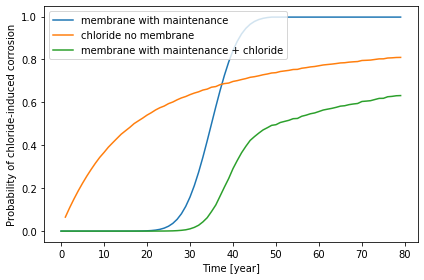

In [91]:
t = np.arange(0, 80, 1)

# horizontal bar external surface
pf_mem_cl_t = pf_mem_cl(
    t,
    pf_membrane_t_curve=(year_lis_main, pf_mem_main),
    pf_cl_t_curve=(year_lis_cl, pf_cl)
)


fig, ax = plt.subplots()
ax.plot(t, np.interp(t, year_lis_main, pf_mem_main, left=pf_mem_main.min(), right=pf_mem_main.max()), "-", label="membrane with maintenance")

ax.plot(t[1:], np.interp(t, year_lis_cl, pf_cl, left=pf_cl.min(), right=pf_cl.max())[1:], "-", label="chloride no membrane")

ax.plot(t, pf_mem_cl_t, "-", label="membrane with maintenance + chloride")

# ax.set_xlim(-5, 160)
ax.set_xlabel("Time [year]")
ax.set_ylabel("Probability of chloride-induced corrosion")
plt.tight_layout()
plt.legend()


# fig.savefig('plots/pf_membrane_with_maintenance_and_chloride_total.pdf', dpi=600)
df_membrane_with_maintenance_and_chloride= pd.DataFrame({'year':t, 
'membrane with maintenance': np.interp(t, year_lis_main, pf_mem_main, left=pf_mem.min(),right=pf_mem.max()),
'chloride no membrane': np.interp(t, year_lis_cl, pf_cl, left=pf_cl.min(), right=pf_cl.max()),
'membrane with maintenance + chloride': pf_mem_cl_t})

df_membrane_with_maintenance_and_chloride.to_csv("tables/pf_membrane_with_maintenance_and_chloride_total.csv", index=None)


In [96]:
np.interp(0.5, 
        df_membrane_with_maintenance_and_chloride['membrane with maintenance + chloride'],            df_membrane_with_maintenance_and_chloride['year'])

50.39774696383837